<a href="https://colab.research.google.com/github/Jahan08/Explainable-AI-Model-Broad-Spectrum-Bacterial-Inhibition/blob/main/Generative_chemistry_with_SAFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Chemistry for Everyone: A Hands-On Guide using SAFE Encodings
This notebook demonstrates the application of generative chemistry to redesign the scaffold of compound 31 from a recent <a href="https://doi.org/10.1021/acs.jmedchem.3c02083">Journal of Medicinal Chemistry paper</a>.  

We will follow these steps:
- Import the 3D structure of compound 31 bound to Cbl-b protein (PDB: 8qtk). The SDF file for 3D structure of compound 31 is provided.
- Generate alternative scaffolds using the <a href="https://safe-docs.datamol.io/stable/index.html">SAFE package </a>from <a href="https://www.valencelabs.com">Valence labs.</a>
- Apply physicochemical and substructure filters to the generated compounds.
- Identify molecules that match the shape and electrostatics of compound 31 in its bound conformation from the crystal structure (PDB: 8qtk).
- Overlay and visualise the top-ranking compounds.  


**The aim of this notebook is to introduce SAFE encodings for generative chemistry.**   
**It is designed to be accessible to researchers of all programming experience levels, allowing anyone to run and understand the process.**

In [ ]:
# install all necessary packages
!pip install -q safe-mol rdkit pandas py3Dmol datamol tqdm mols2grid useful_rdkit_utils
!pip install git+https://github.com/hesther/espsim

In [ ]:
import py3Dmol
from espsim import EmbedAlignConstrainedScore, EmbedAlignScore, ConstrainedEmbedMultipleConfs, GetEspSim, GetShapeSim
from rdkit import Chem
from rdkit.Chem import rdMolAlign, PandasTools, Crippen, AllChem, Draw, rdMolDescriptors
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import IPythonConsole
from copy import deepcopy
from itertools import chain
import numpy as np
import pandas as pd
import mols2grid
from tqdm import tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import safe as sf
import datamol as dm

In [ ]:
tqdm.pandas()
PandasTools.RenderImagesInAllDataFrames(images=True)

In [ ]:
!wget https://raw.githubusercontent.com/moleculeinsight/gen_chemistry/main/8qtk_ligand.sdf -O 8qtk_ligand.sdf

## Import and visualise the 3d structure of compound 31 bound to cbl-b
If you have your own sdf file for any other compound, then you can add that file here

In [ ]:
sdf_file_path = '8qtk_ligand.sdf'
suppl = Chem.SDMolSupplier(sdf_file_path)
main_ligand = next(suppl)
ligand = Chem.AddHs(main_ligand, addCoords=True)
template = Chem.MolFromSmiles('C[C@H](N1C=C(C=C(C2=CC=CC(=C2)[C@]2(C[C@H](C)C2)C2=NN=CN2C)C1=O)C(F)(F)F)C1=CN(C)N=C1')
ligand = AllChem.AssignBondOrdersFromTemplate(template, ligand)

In [ ]:
def draw(mol, confId=0, width=400, height=400, background_color='white'):
    """
    Draws the 3D structure of a molecule using py3Dmol.

    Parameters:
        mol: The molecule to draw, RDKit Mol object.
        confId: The conformer ID to use for drawing. Defaults to 0.
        width: The width of the viewer window. Defaults to 400.
        height: The height of the viewer window. Defaults to 400.
        background_color: The background color of the viewer. Defaults to 'white'.

    Returns:
        The py3Dmol viewer with the molecule displayed.
    """

    if not isinstance(mol, Chem.Mol):
        raise TypeError("The provided mol parameter is not an RDKit Mol object.")

    view = py3Dmol.view(width=width, height=height)
    view.removeAllModels()

    try:
        mol_block = Chem.MolToMolBlock(mol, confId=confId)
    except Exception as e:
        raise RuntimeError(f"Failed to convert molecule to MolBlock: {e}")

    view.addModel(mol_block, 'sdf')
    view.setStyle({'model': confId}, {'stick': {'radius': 0.15}})
    view.setBackgroundColor(background_color)
    view.zoomTo()

    return view.show()

#### After running the cell below, you will see 3D structure of compound 31 as it is bound to Cbl-b in the crystal structure   
The view is interactive, you can rotate or zoom the structure

In [ ]:
draw(ligand)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Scaffold Generation with SAFE.
SAFE offers two key functionalities for connecting fragments:
- Linker Generation
- Scaffold Morphing  

We will use both methods in our scaffold design process. We will generate 500 compounds in each methods, but you can increase the number in `n_samples_per_trial` if you want to generate more compounds and cover extra chemical space.

To begin, I have provided fragments that require scaffold connection. SMILES strings for these fragments are provided, but you can customize them by modifying `fragment1` and `fragment2` in the code below.
**Note**: When customizing fragment SMILES, include a * to indicate the desired connection point to the scaffold. If you're unfamiliar with SMILES notation, most molecular editors can generate these strings for you.

In [ ]:
designer = sf.SAFEDesign.load_default(verbose=True)

/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


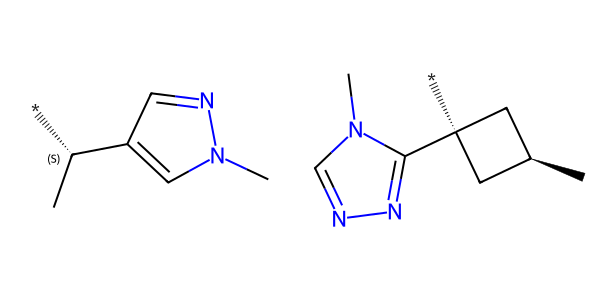

In [ ]:
fragment1 = 'C[C@H](-*)C1=CN(C)N=C1'
fragment2 = "C[C@H]1C[C@](-*)(C1)C1=NN=CN1C"

fragments = f'{fragment1}.{fragment2}'
linker_generation = [fragment1, fragment2]

dm.to_image(linker_generation)

## If you are in rush
The following 2 cells are generating scaffolds using SAFE. Each cell block can take around 10 mins each to run.  
If you are in rush, reduce the number of compounds in `n_samples_per_trial` from 250 to a lower number such as 50 or 100.

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/santosh/Documents/coding/generative_chemistry/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:588: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2024-07-24 23:33:57.360 | INFO     | safe.sample:_fragment_linking:393 - After sanitization, 1000 / 1000 (100.00 %)  generated molecules are valid !


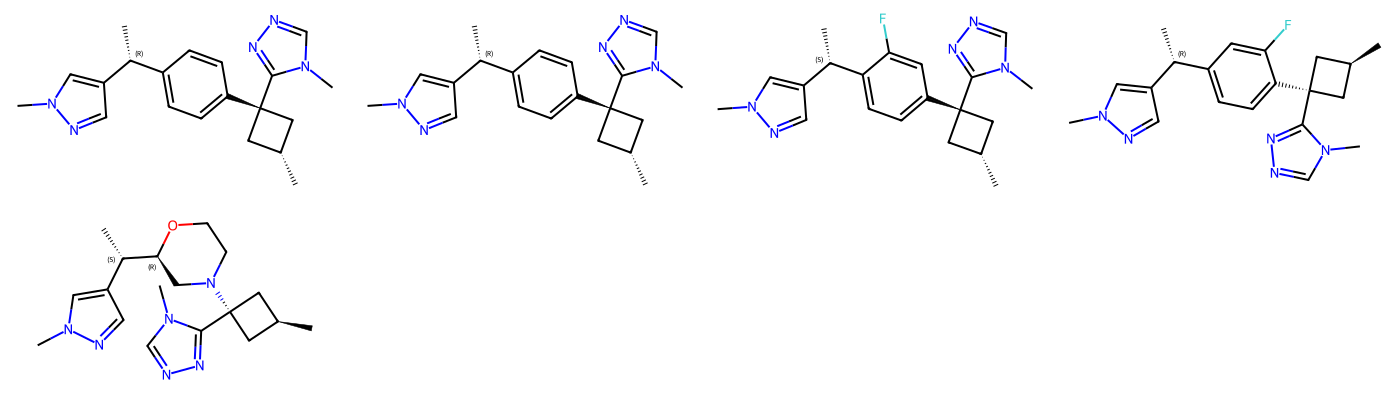

In [ ]:
%%time
generated_smiles_linkers = designer.linker_generation(
    *linker_generation,
    n_samples_per_trial=250,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

dm.to_image(generated_smiles_linkers[:5], mol_size=(350, 200))

  0%|          | 0/2 [00:00<?, ?it/s]

2024-07-24 23:36:35.083 | INFO     | safe.sample:_fragment_linking:393 - After sanitization, 1000 / 1000 (100.00 %)  generated molecules are valid !


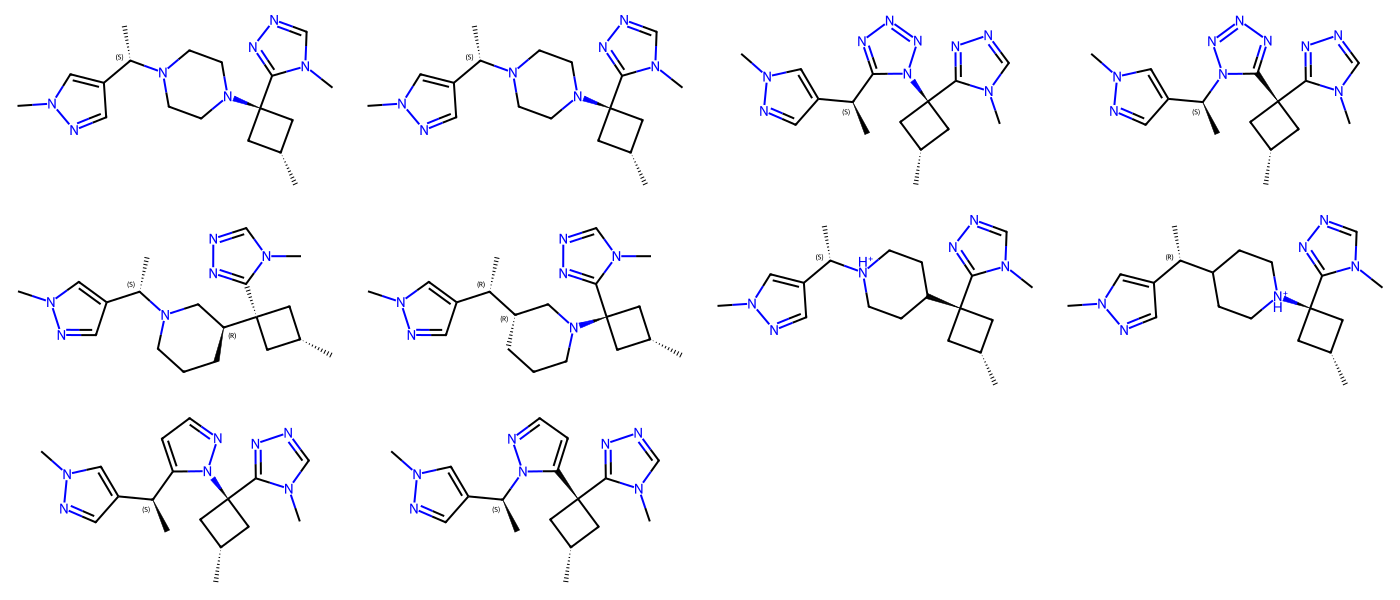

In [ ]:

%%time
generated_smiles_scaffolds = designer.scaffold_morphing(
    side_chains=fragments,
    n_samples_per_trial=250,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

dm.to_image(generated_smiles_scaffolds[20:30], mol_size=(350, 200))

### Validating 3D Similarity Scoring that we will use later.
Below, I've added the SMILES of our original compound 31 as a test.  
Ideally, it should rank as the top hit, as a compound should have the highest 3D similarity with itself.  
While a perfect score of 1 might be expected for both 3D shape and electrostatic similarities, in practice, reproducing the exact conformation is challenging.  
Thus, we anticipate a score close to, but not exactly, 1.

In [ ]:
generated_smiles = generated_smiles_linkers + generated_smiles_scaffolds
generated_smiles.append('C[C@H](N1C=C(C=C(C2=CC=CC(=C2)[C@]2(C[C@H](C)C2)C2=NN=CN2C)C1=O)C(F)(F)F)C1=CN(C)N=C1') #add original compound
print(f'Total generated smiles: {len(generated_smiles)-1}')

Total generated smiles: 2000


## Apply physchem and substrcuture filters

In [ ]:
maindf = pd.DataFrame({'smiles': generated_smiles})
print(f'Total compounds before removing duplicates: {len(maindf)}')
PandasTools.AddMoleculeColumnToFrame(maindf,'smiles','molecule')
maindf['rot_bonds'] = maindf.molecule.apply(rdMolDescriptors.CalcNumRotatableBonds)
maindf['logP'] = maindf.molecule.apply(Crippen.MolLogP)
maindf['HBD'] = maindf.molecule.apply(rdMolDescriptors.CalcNumHBD)
maindf['mw'] = maindf.molecule.apply(rdMolDescriptors.CalcExactMolWt)
maindf['inchi'] = maindf.molecule.apply((Chem.MolToInchiKey))
maindf.drop_duplicates(subset='inchi', inplace=True)
print(f'Total compounds after removing duplicates: {len(maindf)}')

Total compounds before removing duplicates: 2001
Total compounds after removing duplicates: 872


#### The following code removes compounds with unwanted substructures.
I have used the following code from Patrick Walter's <a href="https://github.com/PatWalters/useful_rdkit_utils">useful_rdkit_utils package.</a>

In [ ]:
reos = uru.REOS()
reos.set_active_rule_sets(["Dundee"])
maindf[['rule_set','reos']] = [list(reos.process_mol(x)) for x in maindf.molecule]
uru.value_counts_df(maindf,"reos")

reos  count
0                               ok    741
1                            imine     16
2             Aliphatic long chain     14
3               Thiocarbonyl group     11
4                  isolated alkene     10
5                  2-halo pyridine     10
6                      heavy metal      8
7                      diazo group      7
8                     alkyl halide      6
9      Oxygen-nitrogen single bond      6
10                     nitro group      6
11                         aniline      5
12                          iodine      4
13  charged oxygen or sulfur atoms      4
14           het-C-het not in ring      4
15             quaternary nitrogen      3
16                     triple bond      3
17                        phosphor      2
18                    diketo group      2
19      Three-membered heterocycle      2
20                         N oxide      2
21                     acid halide      2
22                halogenated ring      2
23                       thioester      2

In [ ]:
# I am being generous with these numbers, but please change if you want to.
filtered_df = maindf[
    (maindf['rot_bonds']<10) &
    (maindf['logP']<=5) &
    (maindf['HBD']<= 3) &
    (maindf['mw']<=600) &
    (maindf['reos']=='ok')
]
print (f'Total compounds after triage: {len(filtered_df)}')

Total compounds after triage: 733


### Lets visualise all ring systems in our generated structure.
Thanks to Patrick Walters again for making this really easy.

In [ ]:
ring_system_finder = uru.RingSystemFinder()
filtered_df = filtered_df.copy()
filtered_df['ring_systems'] = filtered_df.molecule.apply(ring_system_finder.find_ring_systems)
ring_list = chain(*filtered_df.ring_systems.values)
ring_series = pd.Series(ring_list)
ring_series.value_counts()
ring_df = pd.DataFrame(ring_series.value_counts()).reset_index()
ring_df.columns = ["SMILES","Count"]
mols2grid.display(ring_df,smiles_col="SMILES",subset=["img","Count"],selection=False)

MolGridWidget()

#### And, here are structures of generated compounds

In [ ]:
mols2grid.display(filtered_df,smiles_col="smiles",selection=False)

MolGridWidget()

## 3D Shape and Electrostatics Similarity calculation
We will now assess the 3D shape and electrostatics similarities of our filtered compounds to the original compound 31. This process involves:

- Generating 70 conformers per compound (adjustable for precision/speed trade-off)
- Aligning these conformers with compound 31's bound structure in PDB: 8qtk
- Calculating similarities using the <a href="https://github.com/hesther/espsim">espsim package</a>. I have used some of the code from notebooks shared in the package documentation.

This analysis helps to identify compounds that best mimic the 3D shape and electronic properties of compound 31 in its protein-bound state.
### Note
**This step is slightly time consuming and can take upto 45-60 minutes, depending on the number of compounds remaining after the filtering step.**   

Sometimes, the conformer generation can get stuck for many minutes for a single molecule.  
This could be because these generative chemistry tools sometimes produce molecules with incorrect stereochemistry assignments. And, rdkit struggles with such molecules. Greg Landrum has highlighted the issue <a href="https://github.com/rdkit/rdkit/issues/4765">here</a>  
If this happens, then all you can do is wait. or, There might be a way to filter out these culprit molecules, but I have not found a way. If you know, please let me know.

**If you are in rush, as mentioned above in the molecule generation by SAFE step, reduce the number of compounds in `n_samples_per_trial` from 250 to a lower number such as 50 or 100.**

In [ ]:
def align(prbMol, refMol, prbCrippen=None, refCrippen=None, prbId=-1, refId=-1):
    """
    Aligns the probe molecule to the reference molecule using Crippen contributions.

    Parameters:
        prbMol: The probe molecule to be aligned.
        refMol: The reference molecule to align to.
        prbCrippen: Precomputed Crippen contributions for the probe molecule. Defaults to None.
        refCrippen: Precomputed Crippen contributions for the reference molecule. Defaults to None.
        prbId: Conformer ID for the probe molecule. Defaults to -1.
        refId: Conformer ID for the reference molecule. Defaults to -1.

    Returns:
        float: The RMSD value of the alignment.
    """
    if not isinstance(prbMol, Chem.Mol):
        raise TypeError("prbMol should be an RDKit Mol object.")
    if not isinstance(refMol, Chem.Mol):
        raise TypeError("refMol should be an RDKit Mol object.")

    if prbCrippen is None:
        prbCrippen = rdMolDescriptors._CalcCrippenContribs(prbMol)
    if refCrippen is None:
        refCrippen = rdMolDescriptors._CalcCrippenContribs(refMol)
    alignment = rdMolAlign.GetCrippenO3A(prbMol, refMol, prbCrippen, refCrippen, prbId, refId)
    return alignment.Align()

In [ ]:
def generate_conformers(mol, num_conformers=50, prune_rms_thresh=0.2, random_seed=0xf00d, num_threads=0):
    """
    Generates conformers for a given molecule.

    Parameters:
        mol: The molecule for which to generate conformers, RDKit mol object.
        num_conformers: The number of conformers to generate. Defaults to 50.
        prune_rms_thresh: RMS threshold for pruning conformers. Defaults to 0.2.
        random_seed: Seed for reproducibility. Defaults to 0xf00d.
        num_threads: Number of threads to use. Defaults to 0. If set to zero, the max supported by the system will be used.

    Returns:
        The molecule with generated conformers.
    """
    if not isinstance(mol, Chem.Mol):
        raise TypeError("mol should be an RDKit Mol object.")

    mol = Chem.AddHs(mol)
    ps = AllChem.ETKDGv3()
    ps.randomSeed = random_seed
    ps.numThreads = num_threads
    ps.pruneRmsThresh = prune_rms_thresh
    ps.useRandomCoords = True
    AllChem.EmbedMultipleConfs(mol, num_conformers, ps)
    return mol

In [ ]:

def calculate_3d_similarities(mol, probe_ligand, num_conformer=50):
    """
    Calculates the 3D shape and electrostatic potential (ESP) similarities between a molecule and a probe ligand.

    Parameters:
        mol: The molecule to compare. RDKit mol object.
        probe_ligand: The probe ligand to compare against.
        num_conformers: The number of conformers to generate for the molecule. Defaults to 50.

    Returns:
        pd.Series: A Pandas series containing the best shape similarity, best ESP similarity, and best total similarity scores.
    """
    best_shape_sim = 0
    best_esp_sim = 0
    best_total_sim = 0
    generated_ligand = generate_conformers(mol, num_conformer)
    for i in range(generated_ligand.GetNumConformers()):
        prbMol=deepcopy(probe_ligand)
        align(prbMol,generated_ligand,prbId=0,refId=i)
        shape_sim = GetShapeSim(prbMol, generated_ligand, prbCid=0, refCid=i)
        esp_sim = GetEspSim(prbMol, generated_ligand, prbCid=0, refCid=i)
        total_sim = shape_sim + esp_sim
        if total_sim>best_total_sim:
            best_total_sim = total_sim
            best_shape_sim = shape_sim
            best_esp_sim = esp_sim
    return pd.Series([best_shape_sim, best_esp_sim, best_total_sim])

In [ ]:
filtered_df = filtered_df.copy()
filtered_df[['shape_sim', 'esp_sim', 'total_sim']] = filtered_df.molecule.progress_apply(calculate_3d_similarities, args=(ligand,70)) # you can change the number of comformers here

100%|██████████| 733/733 [24:30<00:00,  2.01s/it]   


### Top 10 hits

After running the cell below, you will see the top 10 hits by 3D similarity

smiles  \
2000  C[C@H](N1C=C(C=C(C2=CC=CC(=C2)[C@]2(C[C@H](C)C...   
282   C[C@@H](c1cnn(C)c1)n1ccc2cc([C@]3(c4nncn4C)C[C...   
36    C[C@@H](c1cnn(C)c1)n1c(O)nc(NCC[C@]2(c3nncn3C)...   
705   C[C@@H](c1cnn(C)c1)n1cnc2cc([C@]3(c4nncn4C)C[C...   
1686  C[C@@H](c1cnn(C)c1)c1cc2c(o1)CC([C@]1(c3nncn3C...   
1036  C[C@@H](c1cnn(C)c1)N1CCCC([C@]2(c3nncn3C)C[C@@...   
1682  C[C@@H](c1cnn(C)c1)N1CCC2(CC1)CCN([C@]1(c3nncn...   
155   C[C@@H](c1cnn(C)c1)C1CC(c2cncn2[C@]2(c3nncn3C)...   
379   C[C@@H](c1cnn(C)c1)c1csc(CN2CCN([C@]3(c4nncn4C...   
161   C[C@H](CCNc1cnn([C@]2(c3nncn3C)C[C@@H](C)C2)c(...   

                                           molecule  rot_bonds    logP  HBD  \
2000  <rdkit.Chem.rdchem.Mol object at 0x32a575a80>          5  4.7214    0   
282   <rdkit.Chem.rdchem.Mol object at 0x32a546420>          4  3.2236    0   
36    <rdkit.Chem.rdchem.Mol object at 0x32a5337d0>          7  1.5901    2   
705   <rdkit.Chem.rdchem.Mol object at 0x32a551ee0>          4  2.6186    0   
1686  <rdkit.Chem.rdchem.Mol object at 0x32a56d000>          4  3.7662    0   
1036  <rdkit.Chem.rdchem.Mol object at 0x32a55b0d0>          4  3.4697    0   
1682  <rdkit.Chem.rdchem.Mol object at 0x32a56ce40>          4  3.1130    0   
155   <rdkit.Chem.rdchem.Mol object at 0x32a542c00>          5  3.2159    0   
379   <rdkit.Chem.rdchem.Mol object at 0x32a548f20>          6  2.5999    0   
161   <rdkit.Chem.rdchem.Mol object at 0x32a542ea0>          7  1.8845    1   

              mw                        inchi rule_set reos  \
2000  496.219844  QRNMXYQPWPALPI-XOWTYJCDSA-N       ok   ok   
282   375.217144  FJGBYJBSMNMMMP-VFCRVFHLSA-N       ok   ok   
36    412.233522  IRDKURGMQQSDMX-PJSUUKDQSA-N       ok   ok   
705   376.212393  HRMYKUXOVMQURE-PJSUUKDQSA-N       ok   ok   
1686  379.237211  LPSDSJJCJWKFDJ-MFXFUSABSA-N       ok   ok   
1036  370.284495  OJCGVGHWLYNHSP-XGHQBKJUSA-N       ok   ok   
1682  411.311044  LUMKPXDDEJJZPF-YDHSSHFGSA-N       ok   ok   
155   379.248444  WIFRZBKUBCQQIG-GZOPABAHSA-N       ok   ok   
379   440.247064  IAOXCRVLCPJUMO-HOIFWPIMSA-N       ok   ok   
161   396.238608  JDXRUQSCDRFFBQ-STXHMFSFSA-N       ok   ok   

                                           ring_systems  shape_sim   esp_sim  \
2000  [O=c1cccc[nH]1, c1ccccc1, C1CCC1, c1nnc[nH]1, ...   0.625643  0.824940   
282   [c1cn[nH]c1, c1cnc2[nH]ccc2c1, C1CCC1, c1nnc[n...   0.568543  0.808375   
36      [c1cn[nH]c1, O=c1ccnc[nH]1, C1CCC1, c1nnc[nH]1]   0.583240  0.763685   
705   [c1cn[nH]c1, c1cnc2[nH]cnc2c1, C1CCC1, c1nnc[n...   0.567386  0.737692   
1686  [c1cn[nH]c1, c1cc2c(o1)CCCC2, C1CCC1, c1nnc[nH]1]   0.516252  0.777616   
1036       [c1cn[nH]c1, C1CCCNCCC1, C1CCC1, c1nnc[nH]1]   0.494333  0.766669   
1682  [c1cn[nH]c1, C1CC2(CCN1)CCNCC2, C1CCC1, c1nnc[...   0.549491  0.681865   
155   [c1cn[nH]c1, C1CCC1, c1c[nH]cn1, C1CCC1, c1nnc...   0.556849  0.673634   
379   [c1cn[nH]c1, c1cscn1, C1CNCCN1, C1CCC1, c1nnc[...   0.587283  0.641554   
161     [O=c1cccn[nH]1, C1CCC1, c1nnc[nH]1, c1cn[nH]c1]   0.513778  0.705811   

      total_sim  
2000   1.450582  
282    1.376918  
36     1.346925  
705    1.305078  
1686   1.293868  
1036   1.261001  
1682   1.231356  
155    1.230483  
379    1.228837  
161    1.219588
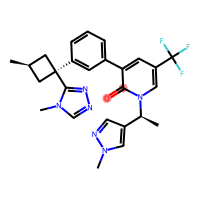
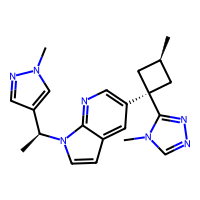
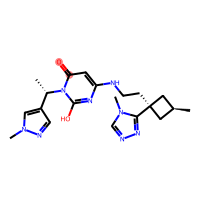
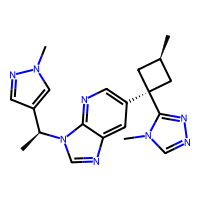
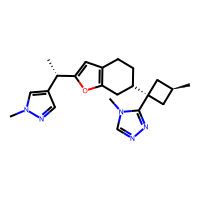
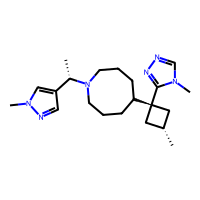
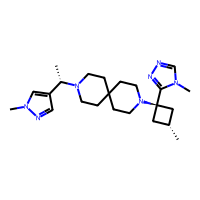
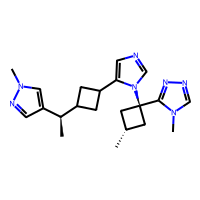
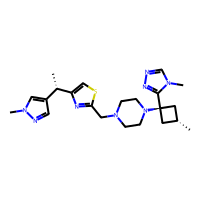
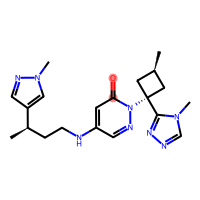

In [ ]:

filtered_df.sort_values(by='total_sim', ascending=False, inplace=True)
filtered_df.head(10) #top 10 hits

## Finally, Visualizing Overlay of Top Hits with Compound 31
The top six hits are displayed. To include more overlays, adjust the `image_grid_size parameter` from (2,3) to your desired dimensions.

In [ ]:
def calculate_3d_similarities_single(mol, probe_ligand, num_conformer=50):
    """
    Calculates the 3D shape and electrostatic potential (ESP) similarities for each conformer of a molecule
    against a probe ligand, and identifies the conformers with the highest ESP similarity and total similarity.

    Parameters:
        mol: The molecule to compare.
        probe_ligand: The probe ligand to compare against.
        num_conformers: The number of conformers to generate for the molecule. Defaults to 50.

    Returns:
        A tuple containing:
            - DataFrame with similarities for each conformer.
            - The molecule with generated conformers.
            - The conformer ID with the highest ESP similarity.
            - The conformer ID with the highest total similarity.
    """

    best_shape_sim = 0
    best_esp_sim = 0
    best_total_sim = 0
    generated_ligand = generate_conformers(mol, num_conformer)
    all_sims = {'shape_sim':[], 'conformer':[], 'esp_sim': [], 'total_sim':[] }

    for i in range(generated_ligand.GetNumConformers()):
        prbMol=deepcopy(probe_ligand)
        align(prbMol,generated_ligand,prbId=0,refId=i)
        shape_sim = GetShapeSim(prbMol, generated_ligand, prbCid=0, refCid=i)
        esp_sim = GetEspSim(prbMol, generated_ligand, prbCid=0, refCid=i)
        total_sim = shape_sim + esp_sim
        all_sims['conformer'].append(i)
        all_sims['shape_sim'].append(shape_sim)
        all_sims['esp_sim'].append(esp_sim)
        all_sims['total_sim'].append(total_sim)

    df = pd.DataFrame.from_dict(all_sims)
    max_espsim_confid = int(df.sort_values('esp_sim', ascending=False)['conformer'].iloc[0])
    max_total_sim_confid = int(df.sort_values('total_sim', ascending=False)['conformer'].iloc[0])
    return df, generated_ligand, max_espsim_confid, max_total_sim_confid


In [ ]:
def draw_overlays(probe_mol, df, rdkit_mol_column = 'molecule', probe_id=0, width=1000, height=600, grid_size=(2,3)):
    """
    Draws the superimposed 3D structures of a probe molecule and a reference molecule using py3Dmol.

    Parameters:
        probe_mol: The probe molecule to be superimposed. RDKit Mol object.
        df: The dataframe that contains 3D similarities scores.
        rdkit_mol_column: Column name in df that contains the rdkit mol object. Defaults to 'molecule'
        ref_mol: The reference molecule to align to. RDKit Mol object.
        probe_id: The conformer ID of the probe molecule.
        ref_id: The conformer ID of the reference molecule.
        width: The width of the viewer window. Defaults to 600.
        height: The height of the viewer window. Defaults to 400.

    Returns:
        The py3Dmol viewer with the superimposed molecules displayed.
    """
    view = py3Dmol.view(width=width, height=height, linked=False, viewergrid=grid_size)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            mol_position_on_df = i*grid_size[1]+j
            index_to_use = df.index[mol_position_on_df]

            aa, ref_mol, ref_id,bb = calculate_3d_similarities_single(df[rdkit_mol_column].loc[index_to_use], ligand, num_conformer=70)

            prbMol=deepcopy(probe_mol)
            align(prbMol,ref_mol,prbId=probe_id,refId=ref_id)

            view.addModel(Chem.MolToMolBlock(prbMol), 'mol', viewer=(i,j))
            view.addModel(Chem.MolToMolBlock(ref_mol, confId=ref_id), 'mol', viewer=(i,j))
            view.setStyle({'stick':{}}, viewer=(i,j))
            view.setStyle({'model':0},{'stick': {'colorscheme': 'greenCarbon'}}, viewer=(i,j))
    view.zoomTo()
    return view.render()
# top_comp_df, top_selected_mol, top_max_espsim_confid, top_max_total_sim_confid = calculate_3d_similarities_single(filtered_df['molecule'].loc[top_scoring_index], ligand, num_conformer=70)

In [ ]:
image_grid_size = (2,3) #Change this grid size to include more hits in overlays
draw_overlays(ligand, filtered_df, rdkit_mol_column = 'molecule', probe_id=0, width=1000, height=600, grid_size=image_grid_size)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### Below are the SAFE generated compounds ranked by their 3d similarities

In [ ]:
mols2grid.display(filtered_df,smiles_col="smiles",selection=False, size=(300, 150), n_items_per_page=12)

MolGridWidget()

## If you have reached this far, you might have generated some cool compounds.
If you like any of the compounds that you see, share them with us.

And, always happy to receive any feedback.